In [1]:
import mlflow.sklearn
import mlflow

In [2]:
mlflow.set_experiment('restaurant_infestation_predictor_test')

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1745625833521, experiment_id='1', last_update_time=1745625833521, lifecycle_stage='active', name='restaurant_infestation_predictor_test', tags={}>

In [3]:
import pandas as pd
import numpy as np
import requests

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import requests

url = "https://data.cityofnewyork.us/resource/3q43-55fe.json"

params = {
    "$limit": 300000,  # Number of records
    "complaint_type": "Rodent",
    "city": "BROOKLYN"
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    print(f"Retrieved {len(data)} records.")
else:
    print(f"Failed to retrieve data: {response.status_code}")


Retrieved 96040 records.


In [6]:
complaints_data = pd.DataFrame(data)
complaints_data['created_date'] = pd.to_datetime(complaints_data['created_date'])
complaints_data['zipcode'] = complaints_data['incident_zip'].astype(str)
complaints_data['month'] = complaints_data['created_date'].dt.to_period('M')

In [7]:
rodent_counts = complaints_data.groupby(['zipcode', 'month']).size().reset_index(name='rodent_complaints')

In [8]:
params = {
    "$limit": 300000,  # Number of records
    "boro" : "Brooklyn"
}

In [9]:
url_health = "https://data.cityofnewyork.us/resource/43nn-pn8j.json"
response_health = requests.get(url_health, params = params)
health_data = pd.DataFrame(response_health.json())

In [10]:
health_data['score'] = pd.to_numeric(health_data['score'], errors='coerce')
health_data['zipcode'] = health_data['zipcode'].astype(str)
health_data['inspection_date'] = pd.to_datetime(health_data['grade_date'])
health_data['month'] = health_data['inspection_date'].dt.to_period('M')
health_data['key'] = health_data['dba'] + health_data['building']

In [11]:
violations = (
    health_data
    .groupby(['key', 'month', 'violation_code'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

In [12]:
zips = health_data[['key', 'zipcode']].drop_duplicates()

In [13]:
health_data_agg = health_data.groupby(['key', 'month']).agg({'score': 'mean'}).reset_index()
health_data_agg = health_data_agg.merge(violations, on=['key', 'month'], how='left')
health_data_agg.sort_values(by=['key', 'month'], inplace=True)

In [14]:
counts = health_data_agg.groupby(['key']).agg({'score': 'count'}).reset_index()

In [15]:
keys = list(counts[counts.score >= 2].key)

In [16]:
health_data_agg = health_data_agg[health_data_agg.key.isin(keys)]

In [17]:
violation_cols = ['10F', '04M', '08A', '09A', '09C', '03A',
       '06A', '06C', '02G', '04L', '06D', '02B', '08B', '06F', '10E', '04D',
       '02H', '04H', '04K', '04O', '10H', '04N', '10B', '04A', '10G', '09B',
       '05D', '10A', '06B', '06E', '10I', '02I', '08C', '28-06', '28-05',
       '09E', '04J', '02A', '04C', '05H', '10D', '02C', '03B', '10C', '03E',
       '03I', '03C', '10J', '02D', '04P', '05B', '05F', '04E', '05A', '05E',
       '06G', '07A', '09D', '04F', '05C', '02F', '04B', '22G', '28-07']

In [18]:
for lag in range(1, 4):
    health_data_agg[f'score_lag{lag}'] = (
        health_data_agg.groupby('key')['score']
          .shift(lag)
    )

    for vc in violation_cols:
          health_data_agg[f'{vc}_lag{lag}'] = (
              health_data_agg
                .groupby('key')[vc]
                .shift(lag)
          )

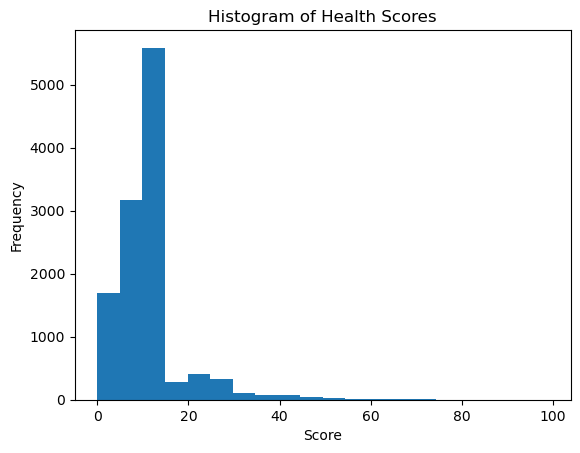

In [19]:
# prompt: Plot histogram of health_data_agg.score

import matplotlib.pyplot as plt

# Assuming health_data_agg is already defined as in your provided code
plt.hist(health_data_agg.score, bins=20) # Adjust the number of bins as needed
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Health Scores')
plt.show()


In [20]:
health_data_agg['pred'] = 0
health_data_agg.loc[(health_data_agg['04L'] > 0) | (health_data_agg['04K'] > 0), 'pred'] = 1
health_data_agg.drop(columns = violation_cols, inplace = True)
health_data_agg = health_data_agg[health_data_agg.score_lag1.notna()]
health_data_agg = health_data_agg.merge(zips, on = 'key')
health_data_agg = health_data_agg.merge(rodent_counts, on = ['zipcode', 'month'], how = 'left')
health_data_agg.drop(columns = 'zipcode', inplace = True)
# health_data_agg.loc[health_data_agg.score > 20, 'pred'] = 1

health_data_agg.drop(columns = 'score', inplace = True)

In [21]:
health_data_agg.pred.value_counts()

pred
0    6117
1    1056
Name: count, dtype: int64

***XGBoost***

In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn import metrics

In [23]:
X = health_data_agg.drop(['key', 'month', 'pred'], axis=1)
y = health_data_agg['pred']

In [24]:
keys = health_data_agg['key']
X = health_data_agg.drop(['key', 'month', 'pred'], axis=1)
y = health_data_agg['pred']

In [25]:
X_train, X_test, y_train, y_test, keys_train, keys_test = train_test_split(
    X, y, keys,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [26]:
df_test_features = X_test.assign(key=keys_test)
df_test_features = df_test_features.assign(y = y_test)

df_test_features.to_csv('test_feats.csv', index = False)

In [27]:
objective = 'auc'
n_estimators=200
learning_rate=0.05
max_depth=6
subsample=0.8
colsample_bytree=0.8
early_stopping_rounds=10

In [30]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

In [31]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric=objective,
    scale_pos_weight=scale_pos_weight,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=42,
    early_stopping_rounds=early_stopping_rounds,
)

In [32]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

[0]	validation_0-auc:0.66723	validation_1-auc:0.61966
[1]	validation_0-auc:0.69820	validation_1-auc:0.58725
[2]	validation_0-auc:0.70455	validation_1-auc:0.61381
[3]	validation_0-auc:0.71316	validation_1-auc:0.62096
[4]	validation_0-auc:0.71993	validation_1-auc:0.61861
[5]	validation_0-auc:0.72831	validation_1-auc:0.63460
[6]	validation_0-auc:0.73359	validation_1-auc:0.63903
[7]	validation_0-auc:0.73179	validation_1-auc:0.64506
[8]	validation_0-auc:0.73408	validation_1-auc:0.64156
[9]	validation_0-auc:0.73484	validation_1-auc:0.64528
[10]	validation_0-auc:0.73852	validation_1-auc:0.64637
[11]	validation_0-auc:0.73959	validation_1-auc:0.64550
[12]	validation_0-auc:0.74069	validation_1-auc:0.64823
[13]	validation_0-auc:0.74376	validation_1-auc:0.65312
[14]	validation_0-auc:0.74447	validation_1-auc:0.65370
[15]	validation_0-auc:0.74604	validation_1-auc:0.65369
[16]	validation_0-auc:0.74923	validation_1-auc:0.65240
[17]	validation_0-auc:0.75207	validation_1-auc:0.65377
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [33]:
y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ROC AUC: 0.6560805996964347
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1224
           1       0.24      0.53      0.33       211

    accuracy                           0.69      1435
   macro avg       0.57      0.62      0.56      1435
weighted avg       0.80      0.69      0.73      1435



In [34]:
roc_auc = metrics.roc_auc_score(y_test, y_proba)

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)

# F1 Score
f1 = metrics.f1_score(y_test, y_pred)

# Recall
recall = metrics.recall_score(y_test, y_pred)

# Precision
precision = metrics.precision_score(y_test, y_pred)

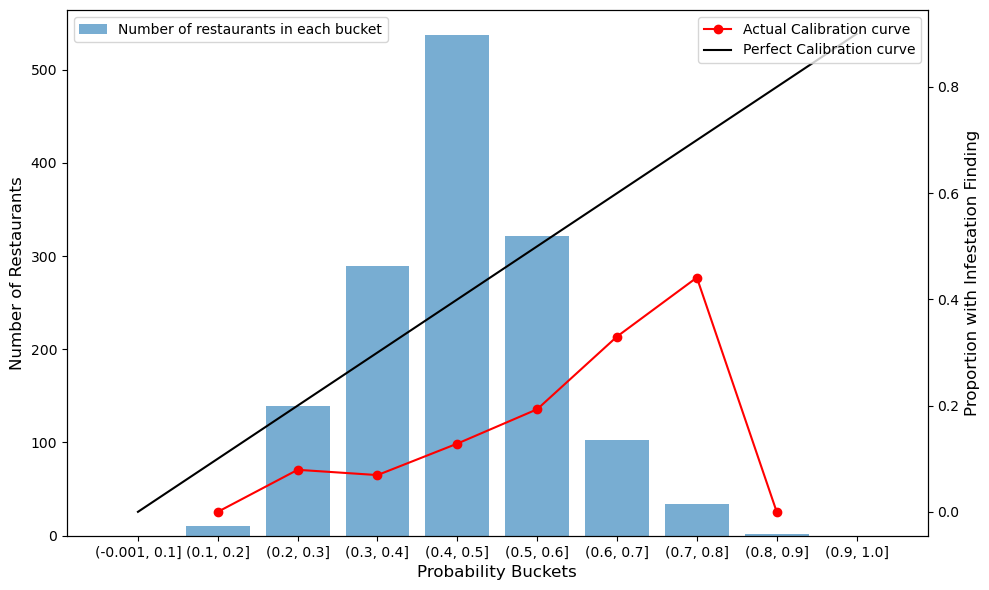

In [35]:
df_results = X_test.copy()
df_results['key']       = keys_test
df_results['actual']    = y_test
df_results['predicted'] = y_pred
df_results['proba_1']   = y_proba

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import pandas as pd

# Define the bins for the probability ranges (0-0.1, 0.1-0.2, ..., 0.9-1)
bins = np.arange(0, 1.1, 0.1)

# Calculate the calibration curve (fraction of positives in each bin)
fraction_of_positives, mean_predicted_value = calibration_curve(df_results['actual'], df_results['proba_1'], 
                                                                n_bins=10, strategy='uniform')

# Assign each probability prediction to a specific bin
df_results['binned'] = pd.cut(df_results['proba_1'], bins=bins, include_lowest=True)

# Calculate the count of predictions per bin (bar plot data)
df_binned = df_results.groupby('binned').size().reset_index(name='count')

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for number of restaurants per probability bucket on primary y-axis
ax1.bar(df_binned['binned'].astype(str), df_binned['count'], alpha=0.6, label='Number of restaurants in each bucket')
ax1.set_xlabel('Probability Buckets', fontsize=12)
ax1.set_ylabel('Number of Restaurants', fontsize=12)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Group by the bins and calculate the fraction of positives
agg_df = df_results.groupby('binned').agg(
    actual_sum=('actual', 'sum'),  # Sum of actual values (count of 1's)
    actual_count=('actual', 'count')  # Count of total observations in the bucket
).reset_index()

agg_df['ratio'] = agg_df.actual_sum / agg_df.actual_count  # Proportion of positives
agg_df['perfect'] = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Plot the calibration curve (fraction of positives) on secondary y-axis
ax2.plot(agg_df['binned'].astype(str), agg_df['ratio'], marker='o', linestyle='-', color='r', label='Actual Calibration curve')
ax2.set_ylabel('Proportion with Infestation Finding', fontsize=12)

ax2.plot(agg_df['binned'].astype(str), agg_df['perfect'], linestyle='-', color='black', label='Perfect Calibration curve')
# Legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [36]:
agg_df.dropna(inplace = True)

x = np.arange(len(agg_df))  # Create an array of indices
y = agg_df['ratio'].values  # The 'ratio' column values

# Perform linear regression to find the slope
slope, intercept = np.polyfit(x, y, 1)  # 1 indicates linear fit

print(f"Slope of the ratio column: {slope}")

Slope of the ratio column: 0.031637291695548034


In [38]:
with mlflow.start_run():
    mlflow.log_param('eval_metric', 'auc')
    mlflow.log_param('scale_pos_weight', scale_pos_weight)
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_param('max_depth', max_depth)
    mlflow.log_param('subsample', subsample)
    mlflow.log_param('colsample_bytree', colsample_bytree)
    mlflow.log_param('early_stopping_rounds', early_stopping_rounds)
    mlflow.log_param('model_type', 'XGBoost')


    mlflow.log_metric('ROC AUC', roc_auc)
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('Calibration slope', slope)

    mlflow.sklearn.log_model(model, 'model')

2025/04/26 00:22:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run adventurous-koi-623 at: http://129.114.27.175:8000/#/experiments/1/runs/d1650cb1107f42799de30e7d22fa8986
🧪 View experiment at: http://129.114.27.175:8000/#/experiments/1


In [39]:
import joblib

# 1) After training your model (brf), dump it to a file:
joblib.dump(model, 'xgb_model.joblib')

['xgb_model.joblib']

***Balnaced RF***

In [40]:
n_estimators = 100
max_depth = 6
sampling_strategy = 'auto'
n_jobs = -1

In [41]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

brf = BalancedRandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    sampling_strategy=sampling_strategy,
    random_state=42,
    n_jobs=n_jobs
)


brf.fit(X_train, y_train)

y_pred  = brf.predict(X_test)
y_proba = brf.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


ROC AUC: 0.6606302078493325

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.61      0.73      1224
           1       0.22      0.62      0.32       211

    accuracy                           0.61      1435
   macro avg       0.56      0.62      0.53      1435
weighted avg       0.80      0.61      0.67      1435



In [42]:
roc_auc = metrics.roc_auc_score(y_test, y_proba)

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)

# F1 Score
f1 = metrics.f1_score(y_test, y_pred)

# Recall
recall = metrics.recall_score(y_test, y_pred)

# Precision
precision = metrics.precision_score(y_test, y_pred)

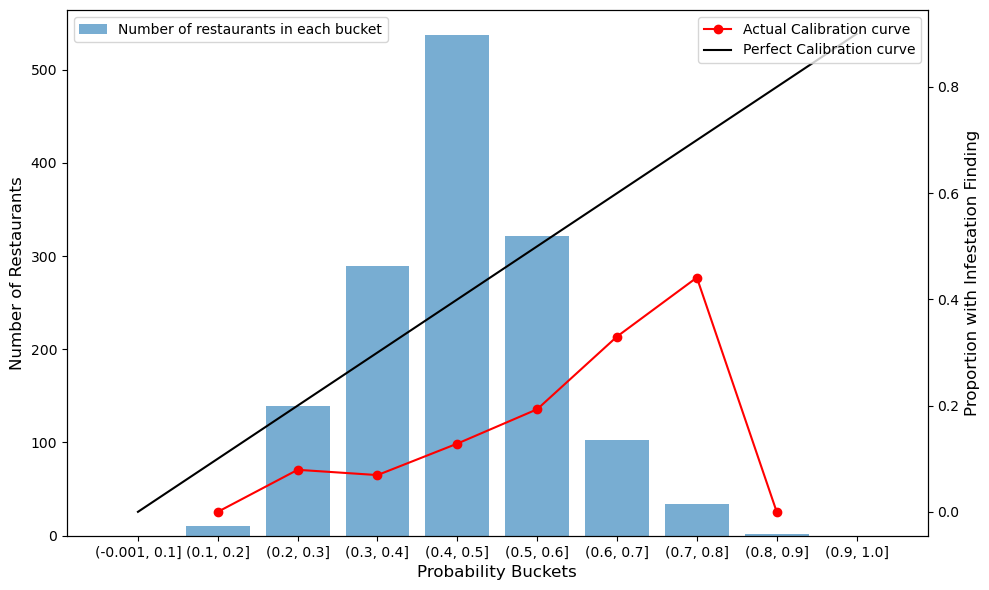

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import pandas as pd

# Define the bins for the probability ranges (0-0.1, 0.1-0.2, ..., 0.9-1)
bins = np.arange(0, 1.1, 0.1)

# Calculate the calibration curve (fraction of positives in each bin)
fraction_of_positives, mean_predicted_value = calibration_curve(df_results['actual'], df_results['proba_1'], 
                                                                n_bins=10, strategy='uniform')

# Assign each probability prediction to a specific bin
df_results['binned'] = pd.cut(df_results['proba_1'], bins=bins, include_lowest=True)

# Calculate the count of predictions per bin (bar plot data)
df_binned = df_results.groupby('binned').size().reset_index(name='count')

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for number of restaurants per probability bucket on primary y-axis
ax1.bar(df_binned['binned'].astype(str), df_binned['count'], alpha=0.6, label='Number of restaurants in each bucket')
ax1.set_xlabel('Probability Buckets', fontsize=12)
ax1.set_ylabel('Number of Restaurants', fontsize=12)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Group by the bins and calculate the fraction of positives
agg_df = df_results.groupby('binned').agg(
    actual_sum=('actual', 'sum'),  # Sum of actual values (count of 1's)
    actual_count=('actual', 'count')  # Count of total observations in the bucket
).reset_index()

agg_df['ratio'] = agg_df.actual_sum / agg_df.actual_count  # Proportion of positives
agg_df['perfect'] = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Plot the calibration curve (fraction of positives) on secondary y-axis
ax2.plot(agg_df['binned'].astype(str), agg_df['ratio'], marker='o', linestyle='-', color='r', label='Actual Calibration curve')
ax2.set_ylabel('Proportion with Infestation Finding', fontsize=12)

ax2.plot(agg_df['binned'].astype(str), agg_df['perfect'], linestyle='-', color='black', label='Perfect Calibration curve')
# Legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
agg_df.dropna(inplace = True)

x = np.arange(len(agg_df))  # Create an array of indices
y = agg_df['ratio'].values  # The 'ratio' column values

# Perform linear regression to find the slope
slope, intercept = np.polyfit(x, y, 1)  # 1 indicates linear fit

print(f"Slope of the ratio column: {slope}")

Slope of the ratio column: 0.031637291695548034


In [47]:
with mlflow.start_run():
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_param('max_depth', max_depth)
    mlflow.log_param('sampling_strategy', sampling_strategy)
    mlflow.log_param('n_jobs', n_jobs)
    mlflow.log_param('model_type', 'Balanced RF')


    mlflow.log_metric('ROC AUC', roc_auc)
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('Calibration slope', slope)

    mlflow.sklearn.log_model(brf, 'model')

2025/04/26 00:25:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dapper-croc-267 at: http://129.114.27.175:8000/#/experiments/1/runs/3e2ceca7ba554163817016317bd417ba
🧪 View experiment at: http://129.114.27.175:8000/#/experiments/1


In [48]:
import joblib

# 1) After training your model (brf), dump it to a file:
joblib.dump(brf, 'brf_model.joblib')

['brf_model.joblib']